In [4]:
% matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import json
import matplotlib.gridspec as gridspec
import copy
import seaborn as sns
from scipy.stats import ttest_1samp
import sys
sys.path.append('..')
from helpers.glove_neighbors import *
from helpers.funcs import *

In [5]:
config = json.load(open('../config.json', 'r'))
DATA_DIR = config['DATA_DIR']
TWEET_DIR = config['TWEET_DIR']
NUM_CLUSTERS = config['NUM_CLUSTERS']
events = open(DATA_DIR + 'event_names.txt', 'r').read().splitlines()

In [6]:
#cluster_method = '_relative'
cluster_method = ''

In [9]:
means = np.load(DATA_DIR + 'cluster_6_means.npy')
glove = pd.read_csv(DATA_DIR+'glove.50d.csv', sep='\t', index_col=0)

In [10]:
for m in means:
    print(neighbors_vector(m, glove).head(25))
    print('-----')

dude      0.499866
yeah      0.503058
eat       0.512343
cuz       0.533348
asshol    0.547755
ass       0.560183
bunch     0.566020
ain       0.566120
ya        0.567236
funni     0.570597
gonna     0.580699
damn      0.586363
unarm     0.586420
huh       0.588224
shit      0.591968
pretti    0.594674
wanna     0.597956
dumb      0.600023
guess     0.600857
oh        0.601347
lol       0.601661
cool      0.602443
bad       0.603353
folk      0.607209
didnt     0.610302
dtype: float64
-----
honor          0.373465
vigil          0.403434
candlelight    0.404665
gather         0.414916
memori         0.450285
tuesday        0.452329
tribut         0.484893
octob          0.512604
sgt            0.512904
oct            0.515183
#smartnew      0.522100
thursday       0.528873
saturday       0.537235
hill           0.548479
pm             0.550990
flown          0.552048
monday         0.555695
staff          0.566937
slain          0.568273
p              0.570777
mourn          0.571342


In [7]:
cluster_names = {0: "other (slang)",
 1: 'remembrance',
 2: 'solidarity',
 3: 'news',
 4: 'laws & policy',
 5: 'ideology'}

# topic proportions

In [12]:
cluster_proportions = {i:[] for i in range(NUM_CLUSTERS)}
for event in events:
    labels = np.load(TWEET_DIR + event + '/' + event + '_cluster_labels_'+str(NUM_CLUSTERS)+cluster_method+'.npy')
    props = np.bincount(labels) / np.sum(np.bincount(labels))
    for i, j in enumerate(props):
        cluster_proportions[i].append(j)

In [13]:
for k, v in cluster_proportions.items():
    print(cluster_names[k], np.mean(v))

other (slang) 0.22479505679070882
remembrance 0.09597706306798612
solidarity 0.13478489704434182
news 0.2593948043431896
laws & policy 0.14968665089786815
ideology 0.13536152785590547


# topic log odds

In [14]:
shooter_race = json.load(open(DATA_DIR + "shooters_race.json","r"))

In [15]:
event_list = []
log_odds_list = []
topic_list = []
race = []
for event in events:
    print(event)
    event_list.extend([event] * NUM_CLUSTERS)
    data = pd.read_csv(TWEET_DIR + event + '/' + event + '.csv', sep='\t', lineterminator='\n',usecols=['dem_follows', 'rep_follows'])
    data = filter_clustered_tweets(event, data, TWEET_DIR, cluster_method[1:])
    data['topic'] = get_clusters(event, TWEET_DIR, cluster_method[1:], NUM_CLUSTERS)
    dem, rep = split_party(data)
    dem_prop = len(dem) / len(data)
    rep_prop = len(rep) / len(data)
    
    for i in range(NUM_CLUSTERS):
        dem_cluster = (dem['topic']==i).sum()
        rep_cluster = (rep['topic']==i).sum()
        total_cluster = dem_cluster + rep_cluster
        dem_val = dem_cluster / (len(dem) - dem_cluster)
        rep_val = rep_cluster / (len(rep) - rep_cluster)
        topic_list.append(cluster_names[i])
        log_odds_list.append(np.log(rep_val / dem_val))
        race.append(shooter_race[event])
        print(cluster_names[i], 'odds', np.log(rep_val / dem_val))
        
    print()
    print('------')
    

chattanooga
other (slang) odds 0.029765253259264803
remembrance odds 0.31821270972701565
solidarity odds -0.2577873746003185
news odds -0.15101101059878494
laws & policy odds 0.185550300151941
ideology odds 0.06614186759603452

------
roseburg
other (slang) odds 0.10783672285612418
remembrance odds -0.06404759614518785
solidarity odds -0.2955051127609218
news odds 0.09299504421178872
laws & policy odds -0.05515215180546843
ideology odds 0.7726349959173116

------
colorado_springs
other (slang) odds -0.13772940902151684
remembrance odds -0.16017480816650187
solidarity odds 0.005060732444785285
news odds 0.8140328141014024
laws & policy odds -0.1328418940654139
ideology odds -0.367686140587078

------
san_bernardino
other (slang) odds -0.14680253907984045
remembrance odds -0.2880073499421782
solidarity odds -0.5070719173732053
news odds -0.006536062512561447
laws & policy odds -0.1724110964370256
ideology odds 0.6582476246616252

------
kalamazoo
other (slang) odds -0.471516173084794
rem

In [16]:
df = pd.DataFrame.from_dict({'event':event_list, 'topic':topic_list, 'log_odds':log_odds_list, 'race':race})

In [17]:
for i, g in df.groupby('topic'):
    print(i)
    print(ttest_1samp(np.array(g['log_odds']), 0))

ideology
Ttest_1sampResult(statistic=3.0002005196236605, pvalue=0.007072705695739765)
laws & policy
Ttest_1sampResult(statistic=-2.001995633709385, pvalue=0.05903409829261063)
news
Ttest_1sampResult(statistic=3.8481979595115, pvalue=0.001003082982265483)
other (slang)
Ttest_1sampResult(statistic=-4.684708518140486, pvalue=0.00014238392939283623)
remembrance
Ttest_1sampResult(statistic=-0.059655029297775296, pvalue=0.9530224555195317)
solidarity
Ttest_1sampResult(statistic=-5.640699792778731, pvalue=1.606008535838092e-05)


[None, None]

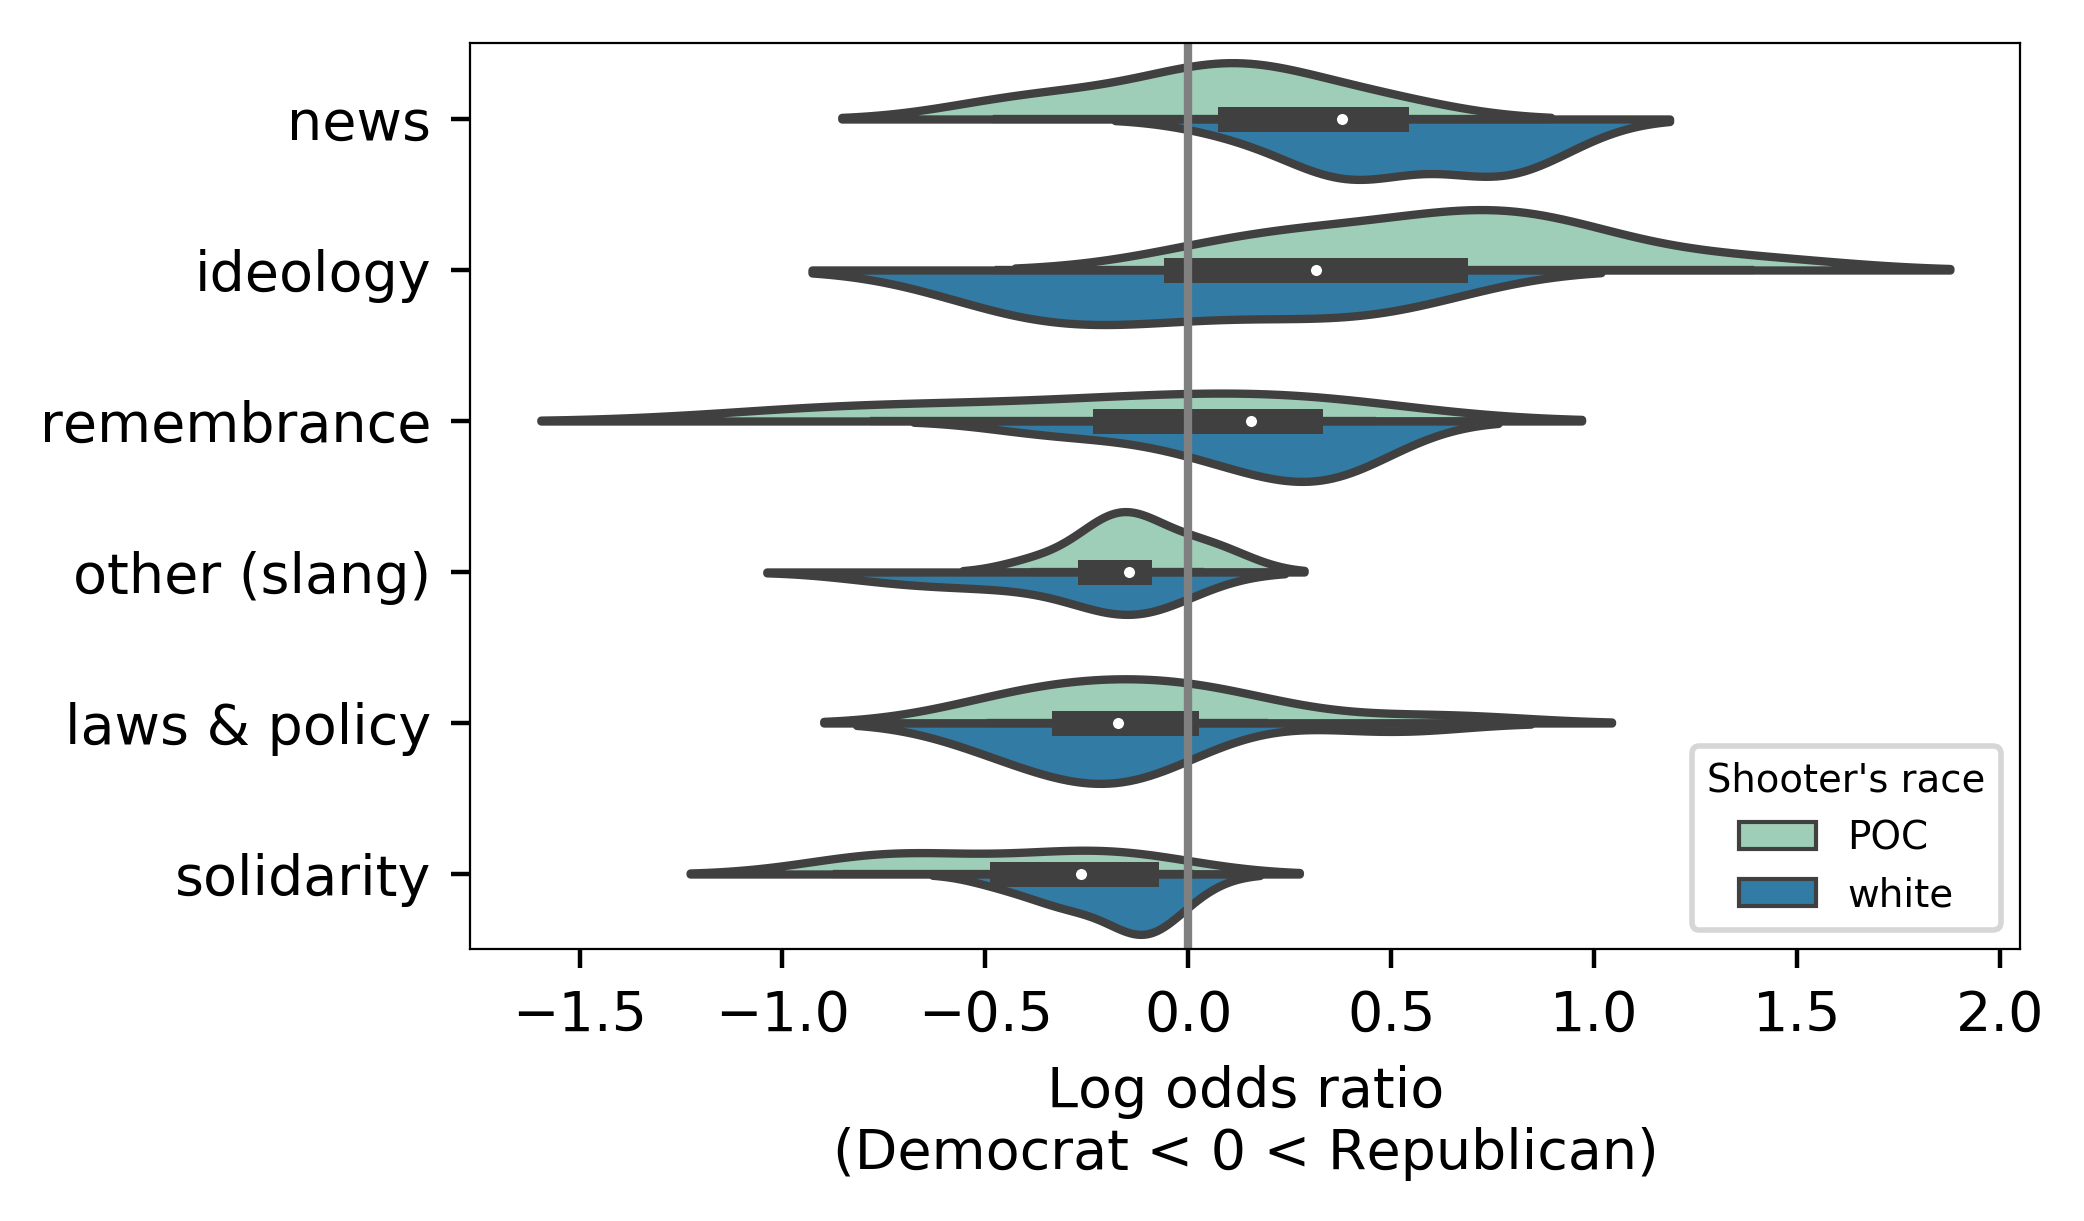

In [18]:
f = plt.figure(dpi=400, edgecolor='grey', figsize=(5,3))
ax = sns.violinplot(data=df, x="log_odds",y="topic", hue='race', split=True, order=reversed(df.groupby('topic').median().sort_values('log_odds').index), orient="h", palette=sns.color_palette("YlGnBu", 2))
ax.set_ylabel('')
ax.spines['top'].set_linewidth(0.4)
ax.spines['right'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.spines['left'].set_linewidth(0.4)
ax.set_xlabel('Log odds ratio\n(Democrat < 0 < Republican)')
plt.axvline(x=0, color='grey')
legend = plt.legend(title="Shooter's race", fontsize=7, loc='lower right')
plt.setp(legend.get_title(),fontsize='x-small')

# plot topic polarization over time

In [1]:
hour = 60 * 60
day = 24 * hour
split_by = 12 * hour
no_splits = int((day / split_by) * 14)  # 14 days

In [10]:
def plot_clusters(events):
    '''Plot polarization over time (average value for all the events in params). We only use ["vegas"] in the paper.'''
    num_splits = 18 # 9 days (splits are made ever 12 hours)
    T = (np.arange(num_splits) + 1) / 2 
    freqs = np.zeros((num_splits, NUM_CLUSTERS, len(events)))  # topic frequencies
    actual = np.zeros((num_splits, NUM_CLUSTERS, len(events)))  # actual leaveout value
    random = np.zeros((num_splits, NUM_CLUSTERS, len(events)))  # random leaveout value
    for k, e in enumerate(events):
        pol = json.load(open(TWEET_DIR + e + '/' + e + '_topic_polarization_over_time'+cluster_method+'.json', 'r'))
        for i in range(num_splits):
            for j in range(NUM_CLUSTERS):
                freqs[i, j, k] = int(pol[str(i)][str(j)][2])
                actual[i, j, k] = float(pol[str(i)][str(j)][0])
                random[i, j, k] = float(pol[str(i)][str(j)][1])
            freqs[i, :, k] = freqs[i, :, k] / np.sum(freqs[i, :, k])  # turn frequencies into topic proportions
        
    mean_freqs = np.mean(freqs, axis=2)
    mean_actual = np.mean(actual, axis=2)
    mean_random = np.mean(random, axis=2)
    
    ro = {0:0, 1:2, 2:3, 3:4, 4:1, 5:5}   # order of plots (i.e. topics), order in plot (key): topic_no (value)
    
    row_num = 2
    col_num = 3
    sns.reset_orig()  # get default matplotlib styles back
    clrs = sns.color_palette('husl', n_colors=NUM_CLUSTERS)  # a list of RGB tuples
    
    #fig, ax = plt.subplots(row_num, col_num, dpi=400, sharex='col', sharey='row')
    fig = plt.figure(dpi=600,figsize=(6.7,3))
    outer = gridspec.GridSpec(row_num, col_num, hspace=0.22, wspace=0.08)
    #fig.subplots_adjust(hspace=0.6, wspace=0.1)

    #fig.suptitle('Temporal polarization of topics', y=.93, fontsize=9)
    # axes are in a two-dimensional array, indexed by [row, col]
    for c in range(row_num * col_num):
        cluster = ro[c]
        inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[c], wspace=0, hspace=.1, height_ratios=[3,1])
        
        for j in range(2):   # the two subplots (polarization and frequency)
            ax = plt.Subplot(fig, inner[j])
            if j == 0:
                ax.set_title(cluster_names[cluster], fontsize=12, y=.95)
                lines = ax.plot(T, mean_actual[:, cluster])  # actual
                lines[0].set_color(clrs[c])
                lines = ax.plot(T, mean_random[:, cluster], '--')  # random
                lines[0].set_color(clrs[c])
                ax.tick_params('y', labelsize=8)
                ax.set_xticks([])
                if c not in [0,3]:
                    ax.tick_params('y', labelsize=8, labelleft=False)
                else:
                    ax.tick_params('y', labelsize=8)
                    ax.set_ylabel('Polarization', fontsize=9)
                ax.yaxis.grid(color='gray', alpha=0.3, linewidth=.5)
                ax.set_ylim(.47, .64)   # set the ylims of the polarization plots
            else:
                ax.bar(T, mean_freqs[:, cluster], color='lightgray', width=.45, edgecolor='darkgrey')
                ax.set_ylim(0, .46)
                #ax.set_yticks([])
                if c not in [0,3]:
                    ax.tick_params('y', labelsize=8, labelleft=False)
                else:
                    ax.tick_params('y', labelsize=8)
                if c not in [3,4,5]:
                    ax.set_xticks([])
                else:
                    ax.set_xticks(np.array([1,3,5,7, 9])+.25)
                    ax.set_xticklabels([int(t) for t in np.array([1,3,5,7, 9])+.25])
                    ax.tick_params('x', labelsize=9)
                if c == 4:
                    ax.set_xlabel('Day after event', fontsize=10)
                if c in [0, 3]:
                    ax.set_ylabel('Freq.', fontsize=8)
                    
                
            ax.spines['bottom'].set_linewidth(0.5)
            ax.spines['left'].set_linewidth(0.5)
            ax.spines['top'].set_linewidth(0.5)
            ax.spines['right'].set_linewidth(0.5)
            fig.add_subplot(ax)
    #outer.tight_layout(fig)
    plt.show()

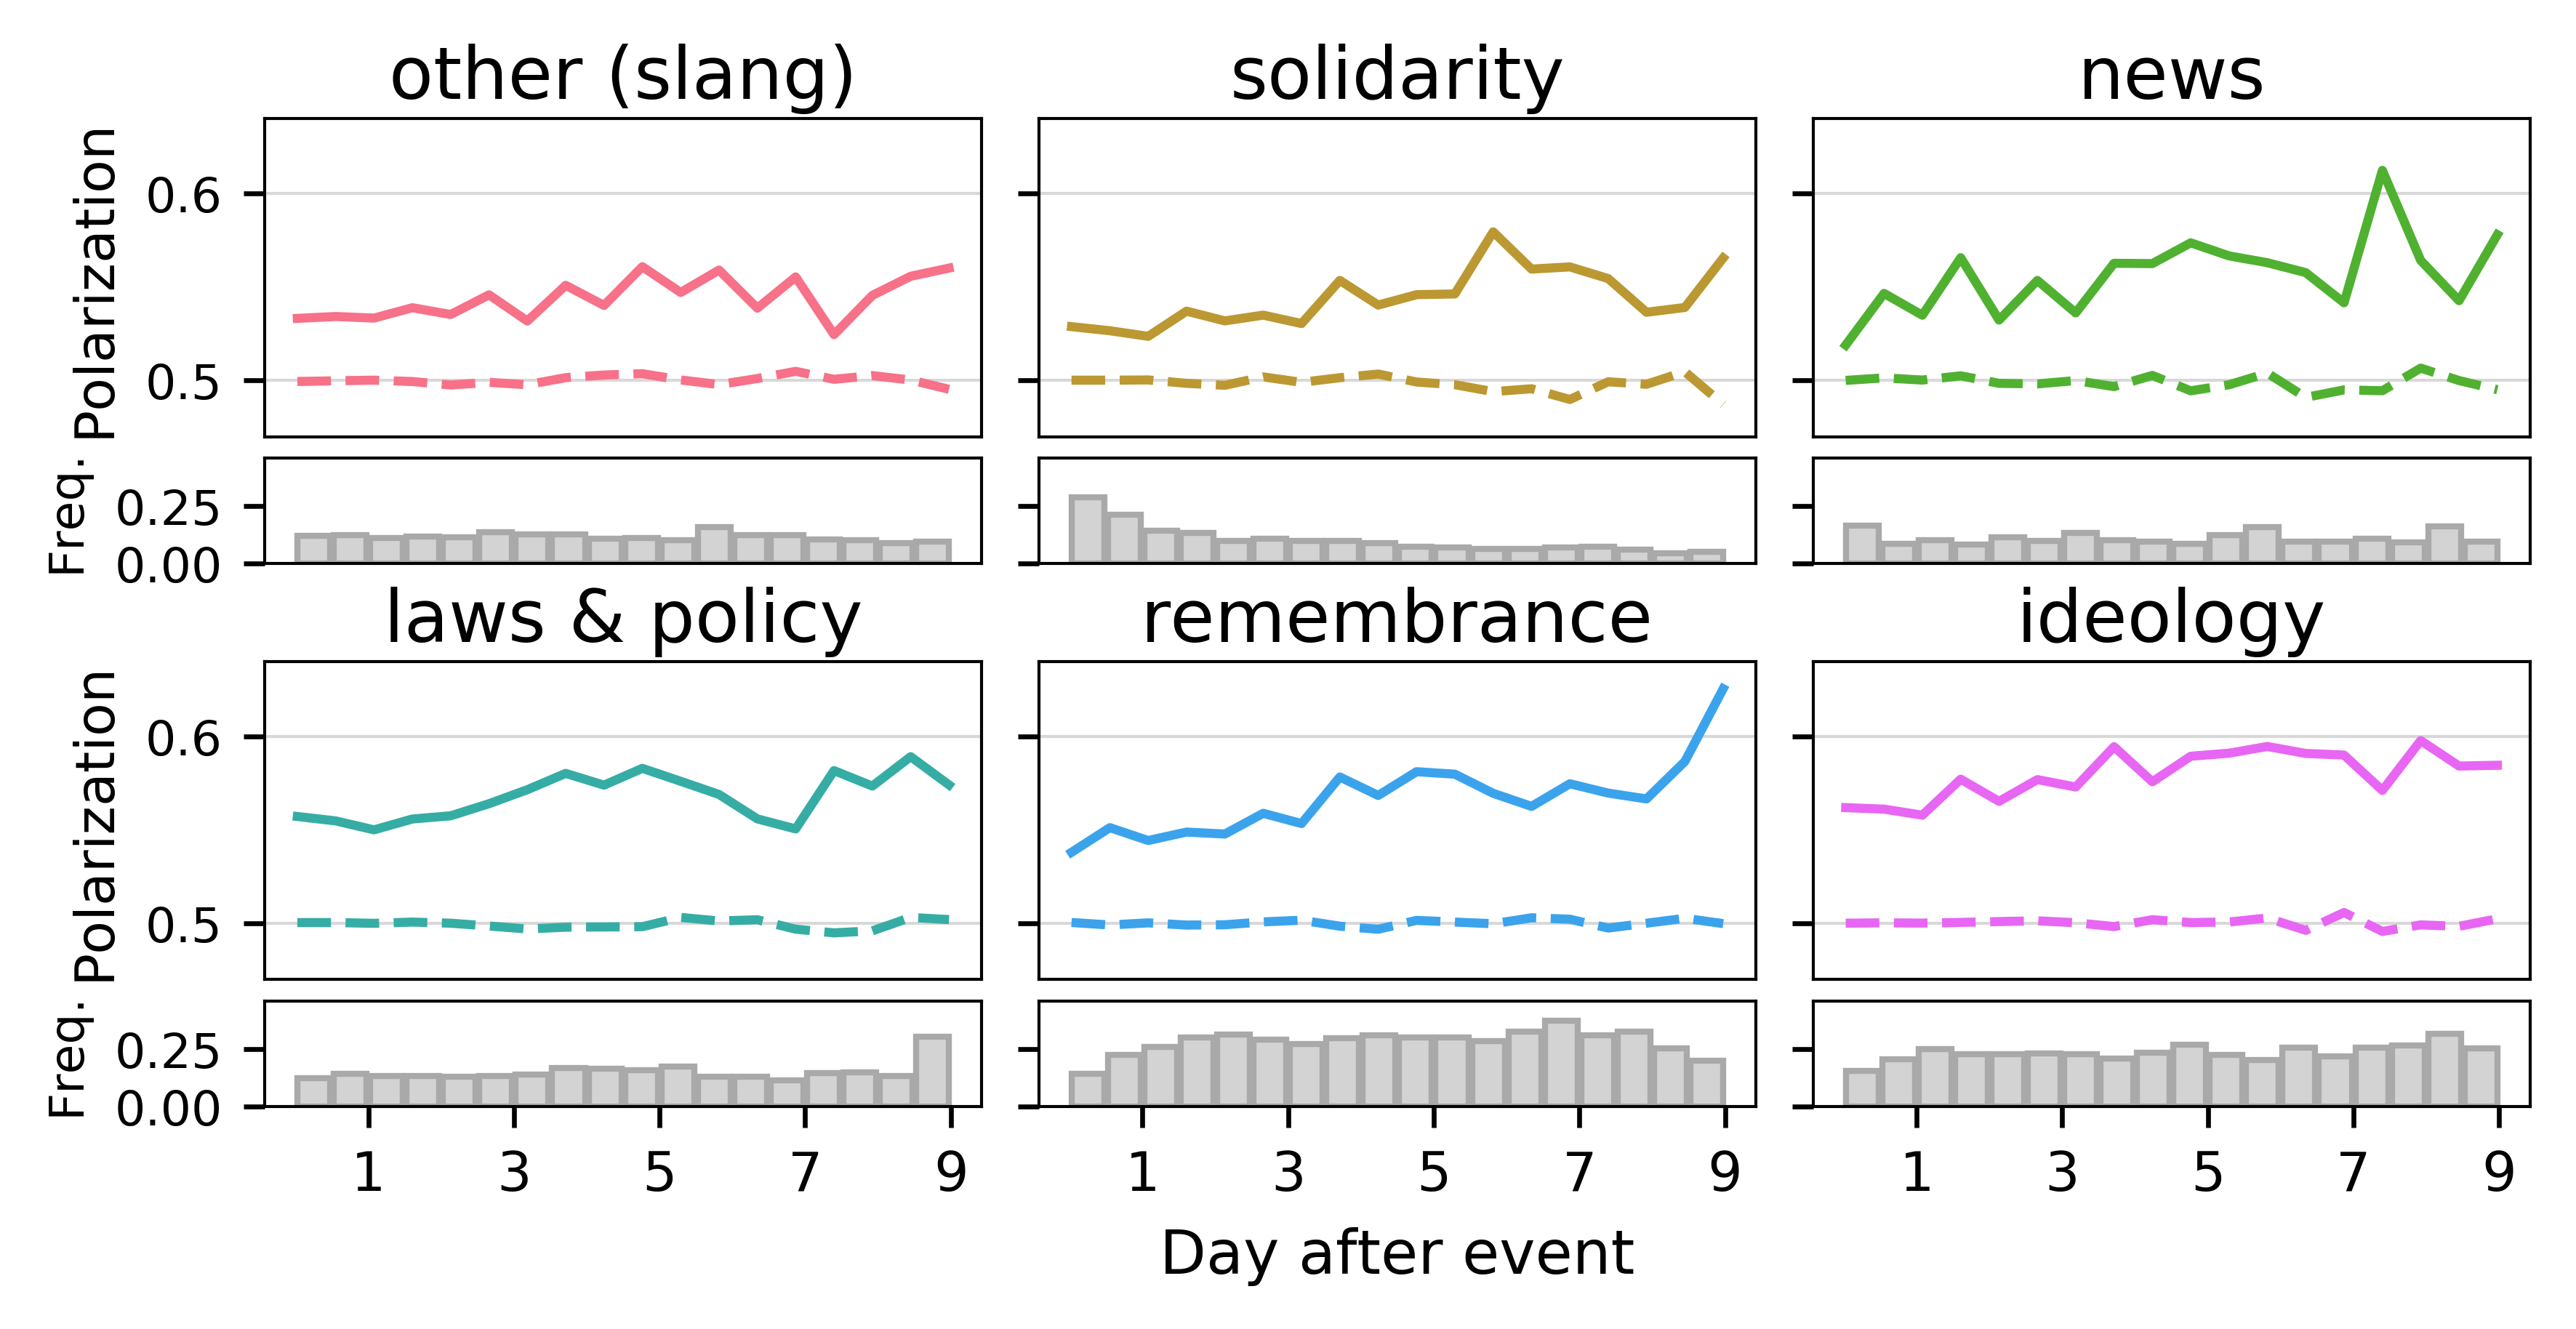

In [12]:
plot_clusters(['orlando'])  # the values from events in the list wil